<a href="https://colab.research.google.com/github/ajheller/notebooks/blob/master/svm_warmup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Data Description

Source: https://archive.ics.uci.edu/ml/datasets/Bar+Crawl%3A+Detecting+Heavy+Drinking#

1. Database Description:

(a) Title

Bar Crawl: Detecting Heavy Drinking

(b) Abstract

Accelerometer and transdermal alcohol content data from a college bar crawl. Used to predict heavy drinking episodes via mobile data.

2. Sources:
   (a) Owner of database
       Jackson A Killian (jkillian@g.harvard.edu, Harvard University); Danielle R Madden (University of Southern California); John Clapp (University of Southern California)
   (b) Donor of database
       Jackson A Killian (jkillian@g.harvard.edu, Harvard University); Danielle R Madden (University of Southern California); John Clapp (University of Southern California)
   (c) Date collected
       May 2017
   (d) Date submitted
       Jan 2020

3. Past Usage:
   (a) Complete reference of article where it was described/used: 
       
Killian, J.A., Passino, K.M., Nandi, A., Madden, D.R. and Clapp, J., Learning to Detect Heavy Drinking Episodes Using Smartphone Accelerometer Data. In Proceedings of the 4th International Workshop on Knowledge Discovery in Healthcare Data co-located with the 28th International Joint Conference on Artificial Intelligence (IJCAI 2019) (pp. 35-42). http://ceur-ws.org/Vol-2429/paper6.pdf

   (b) Indication of what attribute(s) were being predicted
       
Features: Three-axis time series accelerometer data
       
Target: Time series transdermal alcohol content (TAC) data (real-time measure of intoxication)

   (c) Indication of study's results
       
The study decomposed each time series into 10 second windows and performed binary classification to predict if windows corresponded to an intoxicated participant (TAC >= 0.08) or sober participant (TAC < 0.08). The study tested several models and achieved a test accuracy of 77.5% with a random forest.

4. Relevant Information:

    All data is fully anonymized.

Data was originally collected from 19 participants, but the TAC readings of 6 participants were deemed unusable by SCRAM [1]. The data included is from the remaining 13 participants.
   
Accelerometer data was collected from smartphones at a sampling rate of 40Hz (file: all_accelerometer_data_pids_13.csv). The file contains 5 columns: a timestamp, a participant ID, and a sample from each axis of the accelerometer. Data was collected from a mix of 11 iPhones and 2 Android phones as noted in phone_types.csv. TAC data was collected using SCRAM [2] ankle bracelets and was collected at 30 minute intervals. The raw TAC readings are in the raw_tac directory. TAC readings which are more readily usable for processing are in clean_tac directory and have two columns: a timestamp and TAC reading. The cleaned TAC readings: (1) were processed with a zero-phase low-pass filter to smooth noise without shifting phase; (2) were shifted backwards by 45 minutes so the labels more closely match the true intoxication of the participant (since alcohol takes about 45 minutes to exit through the skin.) Please see the above referenced study for more details on how the data was processed (http://ceur-ws.org/Vol-2429/paper6.pdf).

    1 - https://www.scramsystems.com/
    2 - J. Robert Zettl. The determination of blood alcohol concentration by transdermal measurement. https://www.scramsystems.com/images/uploads/general/research/the-determination-of-blood-alcohol-concentrationby-transdermal-measurement.pdf, 2002.

5. Number of Instances:
    Accelerometer readings: 14,057,567
    TAC readings: 715
    Participants: 13

6. Number of Attributes:
    - Time series: 3 axes of accelerometer data (columns x, y, z in all_accelerometer_data_pids_13.csv)
    - Static: 1 phone-type feature (in phone_types.csv)
    - Target: 1 time series of TAC for each of the 13 participants (in clean_tac directory).

7. For Each Attribute:
    (Main)
    all_accelerometer_data_pids_13.csv:
        time: integer, unix timestamp, milliseconds
        pid: symbolic, 13 categories listed in pids.txt 
        x: continuous, time-series
        y: continuous, time-series
        z: continuous, time-series
    clean_tac/*.csv:
        timestamp: integer, unix timestamp, seconds
        TAC_Reading: continuous, time-series
    phone_type.csv:
        pid: symbolic, 13 categories listed in pids.txt 
        phonetype: symbolic, 2 categories (iPhone, Android)
    
    (Other)
    raw/*.xlsx:
        TAC Level: continuous, time-series
        IR Voltage: continuous, time-series
        Temperature: continuous, time-series
        Time: datetime
        Date: datetime

8. Missing Attribute Values:
None

9. Target Distribution:
    TAC is measured in g/dl where 0.08 is the legal limit for intoxication while driving
    Mean TAC: 0.065 +/- 0.182
    Max TAC: 0.443
    TAC Inner Quartiles: 0.002, 0.029, 0.092
    Mean Time-to-last-drink: 16.1 +/- 6.9 hrs

# Load the data

## Phone Data


In [5]:
# import drive 
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [6]:
import pandas as pd
import numpy as np
import scipy as sp
import scipy.linalg as la
import matplotlib.pyplot as plt
from scipy import interpolate
from os import path

# some utility functions
import time
class Timer:
  def __init__(self, report=None):
    self.report = report
  def __enter__(self):
    self.start = time.clock()
    return self
  def __exit__(self, *args):
    self.end = time.clock()
    self.interval = self.end - self.start
    if self.report:
      print(self.report % self.interval)

def decode_ts(ts, unit='auto'):
  if unit == 'auto':
    unit = 'ms' if ts > 1e12 else 's'
  return pd.to_datetime(ts, unit=unit)

In [7]:
### INSERT YOUR PATH to data HERE: ###
data_path = '/content/drive/My Drive/svm-warmup/data'

phone_types = pd.read_csv(path.join(data_path, 'phone_types.csv'))

with Timer("loaded in %d sec\n") as t:
  acc = pd.read_csv(path.join(data_path, 'all_accelerometer_data_pids_13.csv'))

# clean out bad rows
#  see: https://stackoverflow.com/questions/13851535/delete-rows-from-a-pandas-dataframe-based-on-a-conditional-expression-involving
acc.drop(acc[acc['time']==0].index, inplace=True)
acc.reset_index(inplace=True, drop=True) 
acc

loaded in 8 sec



,time,pid,x,y,z
0,1493733882409,SA0297,0.075800,0.027300,-0.010200
1,1493733882455,SA0297,-0.035900,0.079400,0.003700
2,1493733882500,SA0297,-0.242700,-0.086100,-0.016300
3,1493733883945,SA0297,-0.288800,0.051400,-0.014500
4,1493733883953,SA0297,-0.041300,-0.018400,-0.010500
...,...,...,...,...,...
14057560,1493829248196,CC6740,-0.133956,0.124726,-0.010736
14057561,1493829248220,CC6740,-0.100764,0.180872,0.046449
14057562,1493829248245,CC6740,-0.131853,0.195934,0.181088
14057563,1493829248270,CC6740,-0.149704,0.194482,0.202393


In [16]:
phone_types.groupby(by='phonetype').get_group('iPhone')

,pid,phonetype
0,BK7610,iPhone
1,BU4707,iPhone
3,DC6359,iPhone
4,DK3500,iPhone
5,HV0618,iPhone
7,JR8022,iPhone
8,MC7070,iPhone
9,MJ8002,iPhone
10,PC6771,iPhone
11,SA0297,iPhone


In [6]:
pids=acc['pid'].unique()
pids

array(['SA0297', 'PC6771', 'BK7610', 'DC6359', 'MC7070', 'MJ8002',
       'BU4707', 'JR8022', 'HV0618', 'SF3079', 'JB3156', 'CC6740',
       'DK3500'], dtype=object)

In [7]:
acc_by_pid=acc.groupby('pid')

In [8]:
acc_by_pid.count()

,time,x,y,z
pid,,,,
BK7610,1225727,1225727,1225727,1225727
BU4707,447423,447423,447423,447423
CC6740,2374694,2374694,2374694,2374694
DC6359,591358,591358,591358,591358
DK3500,1339622,1339622,1339622,1339622
HV0618,1876013,1876013,1876013,1876013
JB3156,1177748,1177748,1177748,1177748
JR8022,307526,307526,307526,307526
MC7070,318600,318600,318600,318600


In [9]:
acc_by_pid.max()

,time,x,y,z
pid,,,,
BK7610,1493767770640,6.450300,5.344100,4.656500e+00
BU4707,1493757822097,6.298100,4.643600,4.830400e+00
CC6740,1493829248294,27.440683,27.311228,3.072708e+01
DC6359,1493769017080,5.658100,6.986400,5.703800e+00
DK3500,1493809885731,3.584000,5.286900,7.979200e+00
HV0618,1493825233785,4.046400,6.375600,4.258000e+00
JB3156,1493784075509,39.225403,21.285099,1.809008e+08
JR8022,1493772061028,6.181300,8.801400,7.031800e+00
MC7070,1493781545272,7.133000,7.439900,7.631500e+00


In [10]:
[(str(decode_ts(ts_min)), str(decode_ts(ts_max)))
  for ts_min, ts_max in zip(acc_by_pid['time'].min(), acc_by_pid['time'].max())]

[('2017-05-02 14:37:50.653000', '2017-05-02 23:29:30.640000'),
 ('2017-05-02 15:03:24.780000', '2017-05-02 20:43:42.097000'),
 ('2017-05-02 15:56:20.198000', '2017-05-03 16:34:08.294000'),
 ('2017-05-02 14:47:20.950000', '2017-05-02 23:50:17.080000'),
 ('2017-05-02 17:05:09.881000', '2017-05-03 11:11:25.731000'),
 ('2017-05-02 15:28:27.489000', '2017-05-03 15:27:13.785000'),
 ('2017-05-02 15:42:12.016000', '2017-05-03 04:01:15.509000'),
 ('2017-05-02 15:12:42.462000', '2017-05-03 00:41:01.028000'),
 ('2017-05-02 14:50:57.665000', '2017-05-03 03:19:05.272000'),
 ('2017-05-02 14:55:49.591000', '2017-05-03 04:15:51.985000'),
 ('2017-05-02 14:28:08.409000', '2017-05-03 14:24:48.372000'),
 ('2017-05-02 14:04:42.409000', '2017-05-03 15:18:55.776000'),
 ('2017-05-02 15:33:16.712000', '2017-05-03 05:53:45.495000')]

## pick a subject

In [11]:
print(pids)
subject = pids[3]
subject

['SA0297' 'PC6771' 'BK7610' 'DC6359' 'MC7070' 'MJ8002' 'BU4707' 'JR8022'
 'HV0618' 'SF3079' 'JB3156' 'CC6740' 'DK3500']


'DC6359'

In [12]:
# extract acc data for this subject
a = acc[acc['pid']==subject][['x', 'y', 'z', 'time']]
a

,x,y,z,time
88314,0.0003,-0.0001,0.0038,1493736440950
88317,0.0045,-0.0085,-0.0069,1493736440969
88320,0.0054,0.0149,0.0135,1493736441001
88323,0.0142,0.0195,0.0159,1493736441023
88326,0.0439,0.0052,0.0101,1493736441054
...,...,...,...,...
6225317,0.1615,-0.0567,0.1881,1493769016969
6225319,0.2266,-0.0574,0.1966,1493769017001
6225323,0.8460,-0.1478,0.2819,1493769017033
6225326,2.6394,-0.1841,-0.7624,1493769017059


In [13]:
a['z'].max()

5.7038

## plot 3-axis accellerometer data

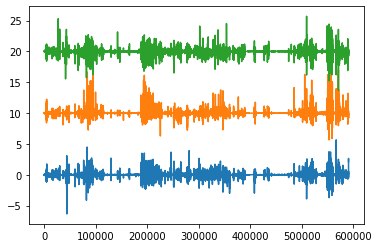

In [14]:
for off, axis in enumerate(['x', 'y', 'z']):
  plt.plot(off*10+a[axis].values)

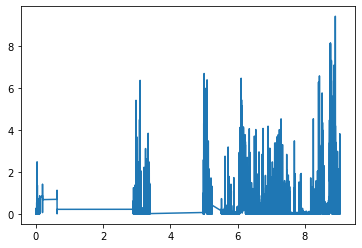

In [15]:
mag = la.norm(a[['x','y','z']].values, ord=2, axis=1)
t = a['time'].values
t_hr = t.astype(np.float64) / 1000 / 3600
plt.plot(t_hr - t_hr[0], mag)
plt.show()

## Load "Clean" TAC data

In [16]:
tac_path = '/content/drive/My Drive/svm-warmup/data/clean_tac/' + subject + '_clean_TAC.csv'

In [17]:
tac = pd.read_csv(tac_path)

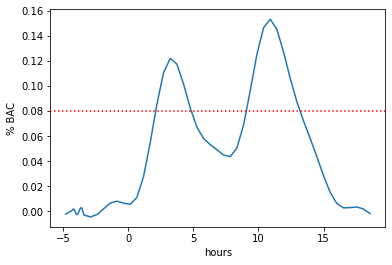

In [18]:
plt.plot((tac['timestamp']-t[0]/1000)/3600, tac['TAC_Reading'])
plt.xlabel('hours')
plt.ylabel('% BAC')
plt.axhline(0.08, ls=':', color='r')
plt.show()

In [19]:
decode_ts(t[0]), decode_ts(tac['timestamp'].min()), decode_ts(tac['timestamp'].max())

(Timestamp('2017-05-02 14:47:20.950000'),
 Timestamp('2017-05-02 10:00:24'),
 Timestamp('2017-05-03 09:20:48'))

## Interpolate BAC and acellerometer readings and plot

In [28]:
# make a 1-D interpolator function
#  bounds_error=False --> return NaNs for x values outside of range
#  TAC data is in seconds, ACC data is in ms

bac = interpolate.interp1d(1000*tac['timestamp'], tac['TAC_Reading'],
                           bounds_error=False)

# values to be plotted 
#  -- separate cell so we can tinker with the plot w/o recalculating
b = bac(t)
b_valid = ~ np.isnan(b)

mag = la.norm(a[['x','y','z']].values, axis=1)
t = a['time'].values
t_hr = t.astype(np.float64) / 1000 / 3600


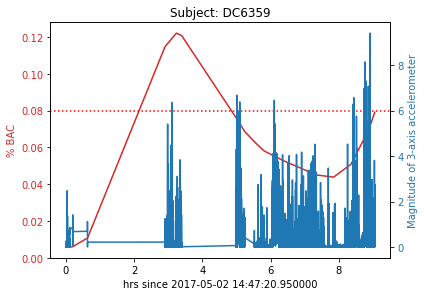

In [26]:
# from https://matplotlib.org/gallery/api/two_scales.html
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel("hrs since " + str(decode_ts(t[0])))
ax1.set_ylabel('% BAC', color=color)
ax1.plot((t_hr - t_hr[0])[b_valid], b[b_valid], color=color)
plt.axhline(0.08, ls=':', color='r')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel("Magnitude of 3-axis accelerometer", color=color)  # we already handled the x-label with ax1
ax2.plot((t_hr - t_hr[0])[b_valid], mag[b_valid], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.title('Subject: ' + subject)
plt.show()